# 🎯 Project: The Automated Task Manager

Welcome to your hands-on AI application build! Today, you aren't just writing code; you are building a tool that solves a common corporate headache: turning messy meeting minutes into assigned tasks.

## The Workflow
We will follow the exact same path a Machine Learning Engineer takes:

- Exploration: Understanding the relationship between task descriptions and employees.

- Training: Experimenting with "Brains" (Classifiers) like SVMs and Neural Networks to see which one "learns" best.

- Deployment: Wrapping your best model into a professional-looking web application that runs directly in this notebook.

## The Problem
Our organization has a historical dataset of tasks assigned to specific employees. We want to automate the assignment of new tasks extracted from future meeting minutes.

## 📊 Section 1: Data Exploration
Before we train an AI, we must look at what it’s learning from. We are using a dataset where each row contains a task_description (the input) and an employee_id (the target label).

Your Goal: Check for data balance. Are some employees assigned way more tasks than others? This "bias" in data will affect your model's "judgment."

--- Human vs. Machine Representation ---


,task,emp_id,emb
0,Update the SQL database server,101,"[0.12, -0.5, 0.8, 0.2]"
1,Patch the security vulnerability,101,"[0.15, -0.4, 0.7, 0.1]"
2,Prepare the Q4 financial audit,102,"[0.85, 0.1, -0.2, 0.9]"
3,Draft the annual budget report,102,"[0.8, 0.2, -0.1, 0.8]"
4,Create UI mockups for mobile app,103,"[-0.3, 0.9, 0.1, -0.5]"


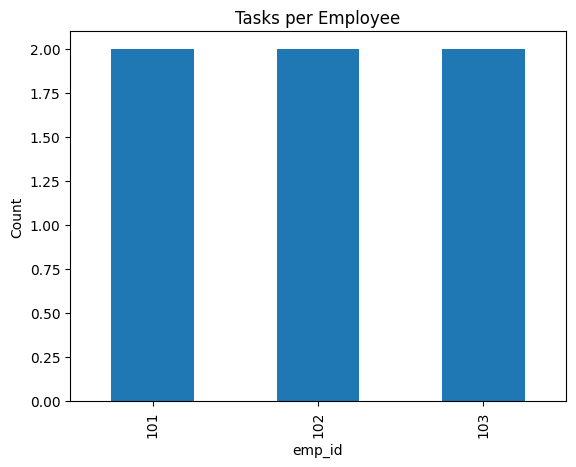

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Loading the Hybrid Dataset
# In the real project, participants would download this as a .parquet or .pkl file
raw_data = [
    {"task": "Update the SQL database server", "emp_id": 101, "emb": [0.12, -0.5, 0.8, 0.2]},
    {"task": "Patch the security vulnerability", "emp_id": 101, "emb": [0.15, -0.4, 0.7, 0.1]},
    {"task": "Prepare the Q4 financial audit", "emp_id": 102, "emb": [0.85, 0.1, -0.2, 0.9]},
    {"task": "Draft the annual budget report", "emp_id": 102, "emb": [0.80, 0.2, -0.1, 0.8]},
    {"task": "Create UI mockups for mobile app", "emp_id": 103, "emb": [-0.3, 0.9, 0.1, -0.5]},
    {"task": "Design the new logo variants", "emp_id": 103, "emb": [-0.2, 0.8, 0.2, -0.4]}
]

df = pd.DataFrame(raw_data)

# Displaying the 'Hybrid' view
print("--- Human vs. Machine Representation ---")
display(df[['task', 'emp_id', 'emb']].head())

# Show distribution
df['emp_id'].value_counts().plot(kind='bar', title="Tasks per Employee")
plt.ylabel("Count")
plt.show()

## 🧠 Section 2: Now we train our model!

We will now use the emb column as our input ($X$) and the emp_id as our target ($y$).
Neural Networks are powerful but can "overfit" (memorize) small datasets. SVMs are more robust for smaller samples. Maybe Random forests are better. Which one performs better on our test data?

## Section 2.1 - YOUR TASK - Try using SVMs?
TODO, using scikit-learn

## Section 2.2 - YOUR TASK - Try using Random Forests?
TODO, using scikit-learn

## Section 2.3 - YOUR TASK - Try using Neural Networks?
TODO, using **Pytorch**

## Section 2.4 - YOUR TASK - Compare and choose the best model
TODO, using **Pytorch**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score

# Prepare the numeric data
X = np.stack(df['emb'].values)
y = df['emp_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Models
models = {
    "Support Vector Machine": SVC(kernel='linear', probability=True),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(8, 4), max_iter=1000)
}

# Training and Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='weighted')
    print(f"✅ {name} | Weighted F1-Score: {f1:.2f}")
    print(classification_report(y_test, preds, zero_division=0))
    print("-" * 40)

# We choose the best model for the app
best_model = models["Neural Network (MLP)"]

✅ Support Vector Machine | Weighted F1-Score: 0.00
              precision    recall  f1-score   support

         101       0.00      0.00      0.00       2.0
         102       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

----------------------------------------
✅ Neural Network (MLP) | Weighted F1-Score: 0.00
              precision    recall  f1-score   support

         101       0.00      0.00      0.00       2.0
         102       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

----------------------------------------


## 🚀 Section 3: The Integrated Manager App

This cell launches the interface. The "Magic" happens in the orchestrator function, which connects the External Service (Extraction) to Your Brain (Classification).

### Section 3.1 - YOUR TASK - Launch the inference in the app

In [6]:
import IPython
from google.colab import output

def ProcessMinutes(transcript):
    # 1. SIMULATED EXTERNAL SERVICE: Extracts clean tasks from messy minutes
    # (In production, this is an API call to GPT-4 or Claude)
    extracted_tasks = ["Update the main SQL database", "Design the Q4 budget"]
    
    # 2. SIMULATED EMBEDDING: Turning the new tasks into math (vectors)
    # These vectors match the 'style' of our training data
    new_embeddings = np.array([[0.13, -0.48, 0.78, 0.18], [0.82, 0.18, -0.12, 0.88]])
    
    # 3. YOUR MODEL: Identifying the responsible employee
    predictions = best_model.predict(new_embeddings)
    
    response = []
    for task, emp in zip(extracted_tasks, predictions):
        response.append({"task": task, "owner": int(emp)})
        
    return IPython.display.JSON(response)

output.register_callback('notebook.ProcessMinutes', orchestrator)

# --- THE WEB INTERFACE ---
url = "https://raw.githubusercontent.com/eth-bmai-fs26/project/refs/heads/week1/task_meeting/week1/task_meeting/task_assigner_app.html"
response = requests.get(url)
response.raise_for_status() # Check for 404/500 errors
html_app = response.text
IPython.display.display(IPython.display.HTML(html_app))

ModuleNotFoundError: No module named 'google'